# Image Classification Finetuning
    
    Step 1: Load the pre-trained model
    Step 2: Freeze the pre-trained layers
    Step 3: Modify the last layer
    Step 4: Load the custom dataset
    Step 5: Define the loss function and optimizer
    Step 6: Train the model
    Step 7: Fine-tune the model on the custom dataset


reference: https://alirezasamar.com/blog/2023/03/fine-tuning-pre-trained-resnet-18-model-image-classification-pytorch/

## ResNet

In [1]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
from torchcam.methods import CAM

model = resnet18(weights=ResNet18_Weights.DEFAULT).eval() # pass weights = None to disable transfer learning
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

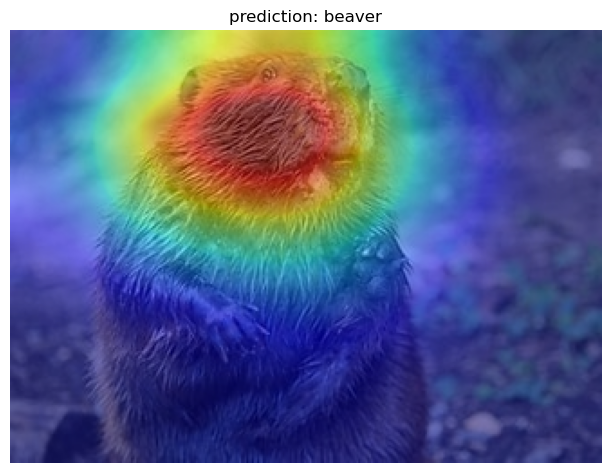

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

weights = ResNet18_Weights.DEFAULT
class_id = weights.meta["categories"].index('beaver')

img = read_image("beaver.jpg")
preprocess = weights.transforms()
batch = preprocess(img).unsqueeze(0)

with SmoothGradCAMpp(model) as cam_extractor:
    out = model(batch)

    predicted_category_name = weights.meta["categories"][out.squeeze(0).softmax(0).argmax().item()]
    
    activation_map = cam_extractor(class_id, out)
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    
    plt.title("prediction: " + predicted_category_name)
    plt.imshow(result)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


(dot.exe:34072): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


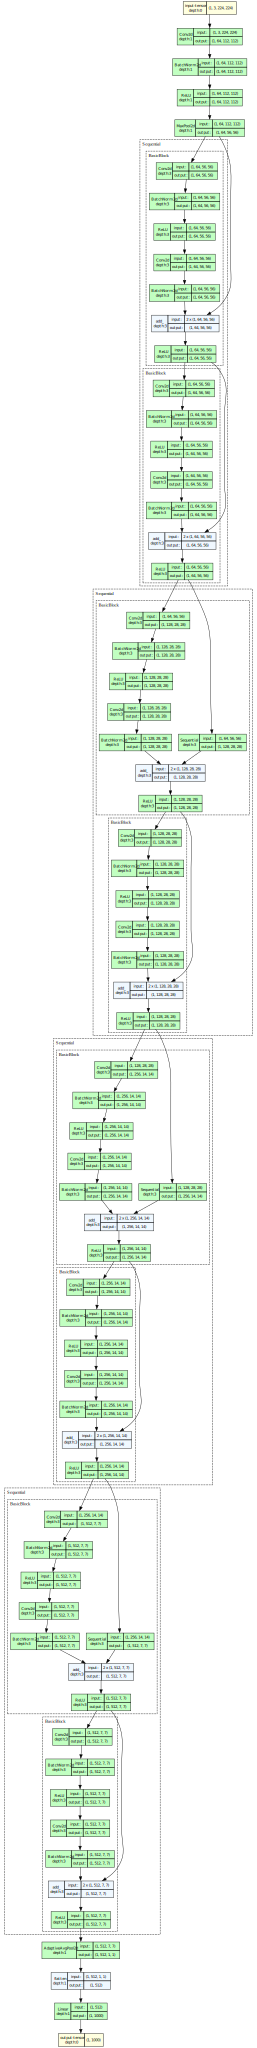

In [3]:
from torchview import draw_graph

'''
The “meta” device is an abstract device which denotes a tensor which records only metadata, but no actual data. Meta tensors have two primary use cases:
    Models can be loaded on the meta device, allowing you to load a representation of the model without actually loading the actual parameters into memory. This can be helpful if you need to make transformations on the model before you load the actual data.
    Most operations can be performed on meta tensors, producing new meta tensors that describe what the result would have been if you performed the operation on a real tensor. You can use this to perform abstract analysis without needing to spend time on compute or space to represent the actual tensors. 
'''

batch_size = 1
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size, 3, 224, 224), expand_nested=True) # device='meta', 
model_graph.visual_graph

In [4]:
import os
DATA_DIR = './中药材224/贝母'
print(os.listdir(DATA_DIR))

# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer of the model
num_classes = len(os.listdir(DATA_DIR)) # replace with the number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

['川贝母 太白贝母 重庆巫溪 品质最优', '川贝母 松贝 野生 四川阿坝州 一般', '川贝母 炉贝 野生 四川阿坝州 最差', '川贝母 青贝 野生 四川阿坝州 一般']


In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    # transforms.Resize(225),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the train and validation datasets
full_dataset = ImageFolder(DATA_DIR, transform=transform)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [0.7, 0.2, 0.1]) 

In [6]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

from torch.utils.data import DataLoader

# Create data loaders for the train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

In [8]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

# Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=2)

Epoch [1/3], train loss: 0.5773, train acc: 0.7679, val loss: 0.1831, val acc: 0.9250
Epoch [2/3], train loss: 0.0459, train acc: 0.9875, val loss: 0.0240, val acc: 1.0000
Epoch [3/3], train loss: 0.0360, train acc: 0.9893, val loss: 0.0155, val acc: 1.0000
Epoch [1/2], train loss: 0.0206, train acc: 0.9964, val loss: 0.0082, val acc: 1.0000
Epoch [2/2], train loss: 0.0112, train acc: 1.0000, val loss: 0.0068, val acc: 1.0000


In [9]:
from datetime import datetime
ts = datetime.today().strftime('%Y%m%d%H%M')
MODEL_NAME = 'resnet18_'+ ts + '.pth'
torch.save(model, MODEL_NAME)

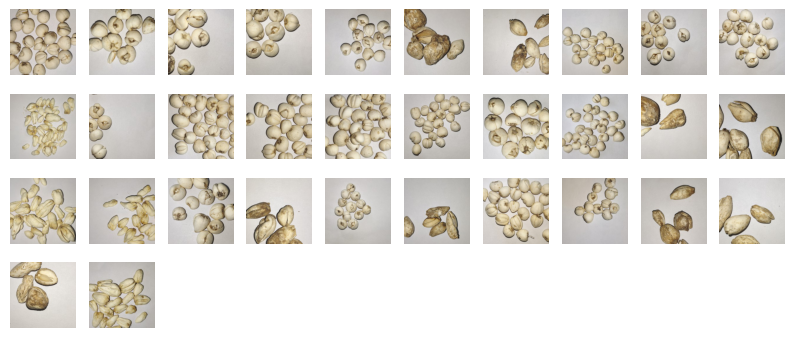

truth: 
 tensor([1, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 3, 1, 1, 1, 1, 3, 1, 2, 2, 0, 0, 3, 2,
        3, 2, 1, 3, 2, 2, 2, 0], device='cuda:0')
prediction: 
 tensor([1, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 3, 1, 1, 1, 1, 3, 1, 2, 2, 0, 0, 3, 2,
        3, 2, 1, 3, 2, 2, 2, 0], device='cuda:0')


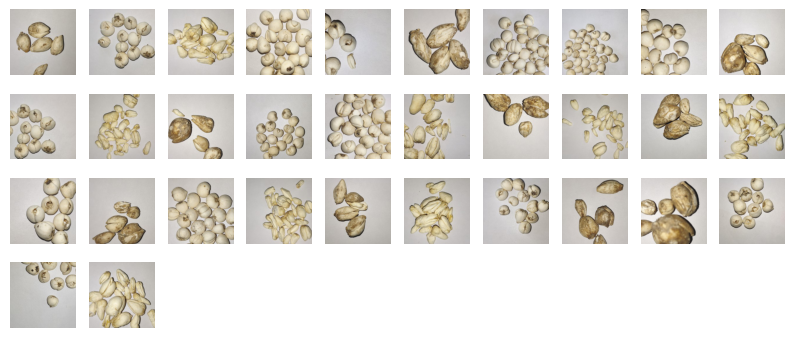

truth: 
 tensor([2, 3, 0, 1, 3, 2, 1, 1, 1, 2, 3, 0, 2, 1, 1, 0, 2, 0, 2, 0, 3, 2, 1, 0,
        2, 0, 3, 2, 2, 3, 3, 0], device='cuda:0')
prediction: 
 tensor([2, 3, 0, 3, 3, 2, 1, 1, 1, 2, 3, 0, 2, 1, 1, 0, 2, 0, 2, 0, 3, 2, 1, 0,
        2, 0, 3, 2, 2, 3, 3, 0], device='cuda:0')


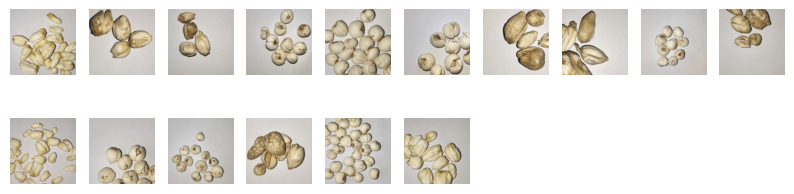

truth: 
 tensor([0, 2, 2, 3, 1, 3, 2, 2, 3, 2, 0, 3, 3, 2, 1, 0], device='cuda:0')
prediction: 
 tensor([0, 2, 2, 3, 1, 3, 2, 2, 3, 2, 0, 3, 3, 2, 1, 0], device='cuda:0')
Test set accuracy (%) = 98.75


In [23]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Model class must be defined somewhere
model = torch.load(MODEL_NAME, weights_only=False).eval()

correct = 0
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

for inputs, labels in test_loader:
    plt.figure(figsize=(10,len(inputs)/10+1))
    for idx, img  in enumerate(inputs):
        plt.subplot(int(len(inputs)/10)+1, 10, idx+1)       
        x = img * STD[:, None, None] + MEAN[:, None, None]
        plt.imshow(x.numpy().transpose(1, 2, 0))
        plt.axis('off')
    plt.show()
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    print('truth: \n', labels)
    print('prediction: \n', preds)
    correct += (preds == labels).float().sum()
    
accuracy = 100 * correct / len(test_dataset)
print('Test set accuracy (%) =', accuracy.item())

# Appendix: Finetune a quantization model

Quantization refers to techniques for performing computations and storing tensors at lower bitwidths than floating point precision. A quantized model executes some or all of the operations on tensors with reduced precision rather than full precision (floating point) values. This allows for a more compact model representation and the use of high performance vectorized operations on many hardware platforms.   
PyTorch supports multiple approaches to quantizing a deep learning model. In most cases the model is trained in FP32 and then the model is converted to INT8. 